<a href="https://colab.research.google.com/github/csabiu/cosmology-class/blob/main/Cosmic_Shear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Download CAMB

In [1]:
!pip install camb

     |████████████████████████████████| 1.6 MB 22.5 MB/s 
  Created wheel for camb: filename=camb-1.3.2-py3-none-any.whl size=1009274 sha256=b91fc9fc3bb697ef8e194b878197378dcc58bf77f45c4ad4a81a30b63409d062
  Stored in directory: /root/.cache/pip/wheels/d3/c1/34/87632240be4218d112bc9b47c18e92ef81bfb6bc1e1f0f0a72
Successfully built camb


### Import Libraries

In [25]:
import numpy as np
import camb
from scipy.integrate import simps
from astropy.cosmology import FlatLambdaCDM
from astropy import constants as const
from scipy.interpolate import interp1d
import astropy.units as u
import astropy.io.fits as fits
import matplotlib.pyplot as plt


### Set the cosmological model

In [68]:
h=0.7
omega_b=0.04
omega_m=0.25
A_baryon1=2.0
mnu=1.0
sigma_8=0.8
n_s=0.96

cosmo = FlatLambdaCDM(H0 = h*100., Om0 = omega_m)
pars = camb.CAMBparams()

#pars.set_cosmology(H0=h*100., ombh2=omega_b*h**2, omch2=(omega_m -omega_b)*h**2 - mnu/93.14, mnu=mnu,omk=0., tau=0.066)
pars.set_cosmology(H0=h*100., ombh2=omega_b*h**2, omch2=(omega_m -omega_b)*h**2 - mnu/93.14, mnu=mnu,omk=0., tau=0.066)

pars.InitPower.set_params(As=2e-09,ns=n_s, r=0)
pars.set_matter_power()
results = camb.get_results(pars)
sigma8=results.get_sigma8()
#print results.get_sigma8()
desired_sigma8=sigma_8
pars.InitPower.set_params(As=2e-09*desired_sigma8**2/sigma8**2,ns=n_s, r=0)
pars.NonLinearModel.set_params(halofit_version='mead')
pars.set_matter_power()

PK1 = camb.get_matter_power_interpolator(pars, k_hunit =False, hubble_units = False, kmax =100)


### Plot the matter power spectrum at fixed redshift

Text(0, 0.5, 'P(k)')

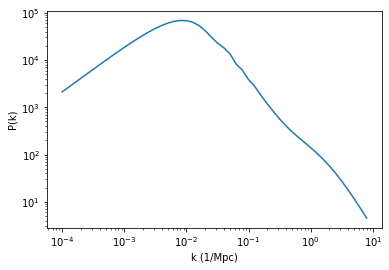

In [73]:
kval=10**np.arange(-4,1,0.1)
plt.loglog(kval,PK1.P(1,kval),'-')
plt.xlabel('k (1/Mpc)')
plt.ylabel('P(k)')

### create the lensing power spectrum

In [89]:
def dz_dx_func(z, cosmo):
    dx_dz = const.c.to('km/s')/cosmo.H0/np.sqrt(cosmo.Om0*(1.+z)**3 + cosmo.Ok0*(1.+z)**2 + (1-cosmo.Om0 - cosmo.Ok0) )
    dz_dx = 1./dx_dz
    return dz_dx.value

def g(z,p_z,cosmo):
    x= cosmo.comoving_distance(z).value
    
    dz_dx = dz_dx_func(z,cosmo)
    
    p_x = p_z*dz_dx
    p_x = p_x/simps(p_x, x)
    
    gi = np.zeros(len(x))
    
    for i in range(1,len(x)):
        
        x_prime = x[i:]
        z_prime = z[i:]
        
        gi[i] = simps(p_x[i:]*cosmo._comoving_transverse_distance_z1z2(z[i],z_prime)/cosmo.comoving_transverse_distance(z_prime),x_prime)
        
    return x, gi

def g_func(x_input,x_min, x_max, g_interp):
    
    if x_input < x_min :
        return g_interp(x_min)
    elif x_input > x_max:
        return g_interp(x_max)
    else:
        return g_interp(x_input)

vg_func = np.vectorize(g_func)


def p_func(x_input,x_min, x_max, p_interp):
    
    if x_input < x_min :
        return 0.
    elif x_input > x_max:
        return 0.
    else:
        return p_interp(x_input)

vp_func = np.vectorize(p_func)

#def Dz(z,cosmo):
#    Omega_m,Omega_lambda = cosmo.Om(z), cosmo.Ode(z)
#    return 1./(1+z)*5./2.*Omega_m*( Omega_m**(4./7.) - Omega_lambda + ( 1. + Omega_m/2.)*(1. +Omega_lambda/70.))**(-1)

def P_mm_ell(ell, z_1,p_z1,z_2, p_z2, cosmo, PK):

    A_factor = cosmo.scale_factor(z_1)
    fk = (cosmo.angular_diameter_distance(z_1).value*(1.+z_1)) # (1+z) factor: converted to comoving scale.
    
    factor = 9./4.*cosmo.Om0**2*(cosmo.H0/const.c.to('km/s'))**4
    
    x_1, g_1 = g(z_1,p_z1,cosmo)
    x_2, g_2 = g(z_2,p_z2,cosmo)

    g_interp = interp1d(x_2, g_2, kind = 'cubic')
    g2_at_1 = vg_func(x_1 ,min(x_2), max(x_2), g_interp)

    vec = g_1*g2_at_1/A_factor**2
    
    PS = np.zeros((len(x_1), len(ell)))

    for i in range(len(x_1)):
        PS[i] = PK.P(z_1[i],((ell+1./2.)/fk[i]))
    
    PS_ell = np.zeros(len(ell))
    for i in range(len(ell)):
        
        PS_ell[i] = simps(PS[:,i]*vec,x_1)
    
    return (factor*PS_ell).value


Text(0.5, 0, '$\\ell$')

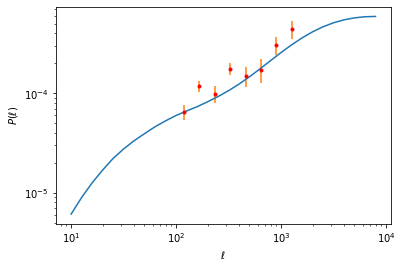

In [102]:
ell=np.asarray((100.,200.))
ell=10**np.arange(1,4,0.1)

err=np.sqrt(np.diag(cov[112:120,112:120]))

pl=P_mm_ell(ell, z,nz,z, nz, cosmo, PK1)
plt.loglog(ell,pl*ell**2)
plt.plot(ell_data[-8:],pl_data[-8:],'r.')
plt.errorbar(ell_data[-8:],pl_data[-8:],yerr=err,linestyle='None')
plt.ylabel(r'$P(\ell)$')
plt.xlabel(r'$\ell$')


In [4]:
!wget http://kids.strw.leidenuniv.nl/DR4/data_files/KiDS1000_cosmic_shear_data_release.tgz

--2021-11-15 12:23:28--  http://kids.strw.leidenuniv.nl/DR4/data_files/KiDS1000_cosmic_shear_data_release.tgz
Resolving kids.strw.leidenuniv.nl (kids.strw.leidenuniv.nl)... 132.229.214.179
Connecting to kids.strw.leidenuniv.nl (kids.strw.leidenuniv.nl)|132.229.214.179|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17283861 (16M) [application/x-gzip]
Saving to: ‘KiDS1000_cosmic_shear_data_release.tgz’

KiDS1000_cosmic_she 100%[===================>]  16.48M  15.1MB/s    in 1.1s    

2021-11-15 12:23:30 (15.1 MB/s) - ‘KiDS1000_cosmic_shear_data_release.tgz’ saved [17283861/17283861]



In [5]:
!tar -zxvf KiDS1000_cosmic_shear_data_release.tgz

KiDS1000_cosmis_shear_data_release/
KiDS1000_cosmis_shear_data_release/._.DS_Store
KiDS1000_cosmis_shear_data_release/.DS_Store
KiDS1000_cosmis_shear_data_release/Read.me
KiDS1000_cosmis_shear_data_release/chains_and_config_files/
KiDS1000_cosmis_shear_data_release/Plotting/
KiDS1000_cosmis_shear_data_release/data_fits/
KiDS1000_cosmis_shear_data_release/data_fits/cosebis_KIDS1000_BlindC_with_m_bias_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_goldclasses_Flag_SOM_Fid.fits
KiDS1000_cosmis_shear_data_release/data_fits/xipm_KIDS1000_BlindC_with_m_bias_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_goldclasses_Flag_SOM_Fid.fits
KiDS1000_cosmis_shear_data_release/data_fits/read_data_files.py
KiDS1000_cosmis_shear_data_release/data_fits/bp_KIDS1000_BlindC_with_m_bias_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_goldclasses_Flag_SOM_Fid.fits
KiDS1000_cosmis_shear_data_release/Plotting/._plot_chains.py
KiDS1000_cosmis_shear_data_release/Plotting/plot_chains.py
K

In [18]:
stats_name ='bp'
dir='KiDS1000_cosmis_shear_data_release/data_fits/'
cat_version = 'V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_goldclasses_Flag_SOM_Fid'
filename = dir+stats_name+'_KIDS1000_BlindC_with_m_bias_'+cat_version+'.fits'
F=fits.open(filename)

# Gives the names of all the extension
F.info()


Filename: KiDS1000_cosmis_shear_data_release/data_fits/bp_KIDS1000_BlindC_with_m_bias_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_goldclasses_Flag_SOM_Fid.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  COVMAT        1 ImageHDU        13   (200, 200)   float64   
  2  PneE          1 BinTableHDU     29   80R x 5C   [K, K, K, D, D]   
  3  PeeE          1 BinTableHDU     29   120R x 5C   [K, K, K, D, D]   
  4  NZ_LENS       1 BinTableHDU     22   79R x 5C   [D, D, D, D, D]   
  5  NZ_SOURCE     1 BinTableHDU     36   119R x 8C   [D, D, D, D, D, D, D, D]   


In [90]:
# Covariance matrix
ext=F["COVMAT"]
cov=ext.data

# cosmic shear data vector
ext=F['PeeE']
data_vector=ext.data['VALUE']

# nofz sources (shear)
ext=F["nz_source"]

#F.close()


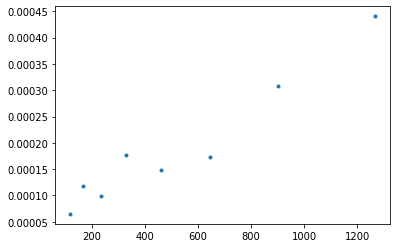

In [85]:
pl_data=F['PeeE'].data['Value']
ell_data=F['PeeE'].data['Ang']
plt.plot(ell_data[-8:],pl_data[-8:],'.')

In [31]:
# GGL data vector
ext=F['PeeE']
data_vector=ext.data['VALUE']

ext.data


FITS_rec([(1, 1, 1, -6.48605359e-06,  118.44199222),
          (1, 1, 2, -2.53898590e-05,  166.15641416),
          (1, 1, 3,  2.88190693e-05,  233.09261732),
          (1, 1, 4,  2.34838865e-05,  326.99410688),
          (1, 1, 5,  5.08786488e-06,  458.72386334),
          (1, 1, 6,  1.88461980e-05,  643.52102491),
          (1, 1, 7, -7.92423462e-05,  902.76382502),
          (1, 1, 8,  5.39553118e-04, 1266.44273027),
          (1, 2, 1, -3.65071754e-06,  118.44199222),
          (1, 2, 2,  1.47162393e-05,  166.15641416),
          (1, 2, 3,  1.17010141e-05,  233.09261732),
          (1, 2, 4,  3.19546881e-06,  326.99410688),
          (1, 2, 5,  3.68246406e-05,  458.72386334),
          (1, 2, 6,  1.38584033e-06,  643.52102491),
          (1, 2, 7,  1.25762863e-05,  902.76382502),
          (1, 2, 8,  1.47464772e-04, 1266.44273027),
          (1, 3, 1, -2.58813222e-05,  118.44199222),
          (1, 3, 2,  1.50333057e-05,  166.15641416),
          (1, 3, 3,  6.77309391e-06,  233.0926

(0.0, 2.5)

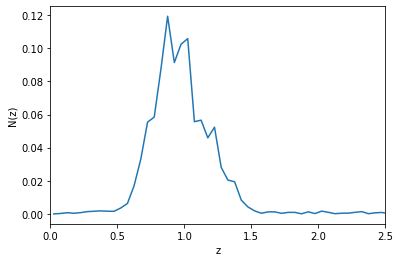

In [75]:
a=F["nz_source"]
z=a.data['Z_MID']
nz=a.data['BIN5']
plt.plot(z,nz,'-')
plt.xlabel('z')
plt.ylabel('N(z)')
plt.xlim((0,2.5))

In [45]:
F['PeeE'].data

FITS_rec([(1, 1, 1, -6.48605359e-06,  118.44199222),
          (1, 1, 2, -2.53898590e-05,  166.15641416),
          (1, 1, 3,  2.88190693e-05,  233.09261732),
          (1, 1, 4,  2.34838865e-05,  326.99410688),
          (1, 1, 5,  5.08786488e-06,  458.72386334),
          (1, 1, 6,  1.88461980e-05,  643.52102491),
          (1, 1, 7, -7.92423462e-05,  902.76382502),
          (1, 1, 8,  5.39553118e-04, 1266.44273027),
          (1, 2, 1, -3.65071754e-06,  118.44199222),
          (1, 2, 2,  1.47162393e-05,  166.15641416),
          (1, 2, 3,  1.17010141e-05,  233.09261732),
          (1, 2, 4,  3.19546881e-06,  326.99410688),
          (1, 2, 5,  3.68246406e-05,  458.72386334),
          (1, 2, 6,  1.38584033e-06,  643.52102491),
          (1, 2, 7,  1.25762863e-05,  902.76382502),
          (1, 2, 8,  1.47464772e-04, 1266.44273027),
          (1, 3, 1, -2.58813222e-05,  118.44199222),
          (1, 3, 2,  1.50333057e-05,  166.15641416),
          (1, 3, 3,  6.77309391e-06,  233.0926